# The Issue Description

Consider that we need some fast prediction of timeseries. Here I'm going to use ARIMA, which requires a lot of different input values: we have to estimate acf, pacf, AIC, etc.

In this case, I'm going to unify the approach for fast selecting these attributes, using only the proportion between train and test samples and the number of steps for further prediction.

In [1]:
import pandas as pd
import numpy as np
import typing as tp
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
import itertools
from statsmodels.tsa.arima_model import ARIMA 
import warnings

# ARIMA

ARIMA consists of several attributes.

Autoregressive model (AR) of timeseries - assumes that each further value linearly depends on several previous value. Generally, it could be described in the following way:

AR(p): X_t = c + sum (a_i * X_t-i) + e_t , where t and i are indexes, X_t - the value at time t, X_t-1 - the value at previous time point, x_t-i - the value at i points before, a_i - model coefficients, с - constant (zero mostly), e_t - white noise (stationary with zero variance).
 
The i index is ranged from 1 to p, where p is the order (number of time lags) of the autoregressive model, which determines the number of previous points and their coefficients. 

The moving average model (MA) is used for observational errors calculating.  

MA(q): X_t = sum (b_j * e_t-j), где t and j are indexes, b_j - model attributes (b_0 is equal to 1), j is ranged from 0 to q, where q is q is the order of the moving-average mode. For example, white noise is the result of M(0): X_t = e_t + b * e_t-1

Autoregressive moving average (ARMA) is used for forecasting stationary timeseries, which don't change their specifications over time.   

ARMA(p,q): X_t = c + sum (a_i * X_t-i) + e_t + sum (b_j * e_t-j)

Non-stationary processes require additional attributes to make them stationary. It could become stationary after several differentiations, where d is the degree of differentiation (the number of times the data have had past values subtracted). Such series are called autoregressive integrated moving average models (ARIMA). Under the condition d = 0, the time series is stationary.

ARIMA (p,d,q): L_d (X_t) = c + sum (a_i * L_d (X_t-i) ) + e_t + sum (b_j * e_t-j)

There are several ways to evaluate p, d and q values, but I want to compare the modeling results with different combinations. I'm going to use MAPE - the mean absolute percentage error between trained and test samples.

In [9]:
warnings.filterwarnings("ignore")

def params(
    df_input: tp.Any
    , n: float
    , m: int
    ) -> tp.Any :
    """
    choose the parameters of the model corresponded to minimum value of MAPE between trained prediction and test sample 
    n is the proportion between train and test sample
    m is the number of prediction steps after the sample end 
    """
    k = int(round(df_input.shape[0] * n))
    df_train = df_input[:k]
    df_test = df_input[k:]
    
    p = range(0,9)
    d = range(0,9) 
    q = range(0,9)

    list_params = []
    list_mape = []

    # genereting all p, d and q combinations
    pdq = list(itertools.product(p, d, q)) 

    for param in pdq:
        try:
            model = ARIMA(df_train.value, order = param) 
            model_result = model.fit() 
            fc, se, conf = model_result.forecast(df_test.shape[0])  
            mape = np.mean(np.abs(fc - df_test.value) / np.abs(df_test.value))  
            list_params.append(param)
            list_mape.append(mape)
        except:
            continue
    
    # choosing better one in terms of the mean absolute percentage error based on the test sample
    min_mape = min(list_mape)
    min_mape_index = list_mape.index(min_mape)
    min_mape_params = list_params[min_mape_index]
    p = min_mape_params[0]
    d = min_mape_params[1]
    q = min_mape_params[2]
    
    # thaining the model on the chosen attributes
    model_result = (ARIMA(df_train.value, order = (p, d, q))).fit()

    fc, se, conf = model_result.forecast(df.shape[0] - k + m, alpha = 0.05)  

    # prediction results
    fc_series = pd.Series(fc, index = range(df_train.shape[0], df.shape[0] + m))
    lower_series = pd.Series(conf[:, 0], index = range(df_train.shape[0], df.shape[0] + m))
    upper_series = pd.Series(conf[:, 1], index = range(df_train.shape[0], df.shape[0] + m))

    # visualization
    plt.plot(df_train.value, label = 'train sample', color = "yellow")
    plt.plot(df_test.value, label = 'test sample', color = "blue")
    plt.plot(fc_series, label = 'prediction over test', color = "red")
    plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha = 0.05)
    plt.title('Prediction result', fontweight = "bold", size = 16)
    plt.legend(loc = 'upper left', fontsize = 10)
    plt.show()
        
    return p, d, q, min_mape

As I have mentioned, the key goal of this exercise is to save time for choosing attributes as well as to check if the dataset could be at all solved via ARIMA - at least seasonal attributes should be enriched by SARIMAX or by using another type of prediction. Let's see how it works on some random dataset from Kaggle.

# Modelling

Time Series Forecasting with Yahoo Stock Price
https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price

In [12]:
df = pd.read_csv("yahoo_stock.csv", sep = ",")
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [18]:
df = df[["Date", "Close"]]
df = df.rename(columns = {"Close": "value"})
df.shape[0]

1825

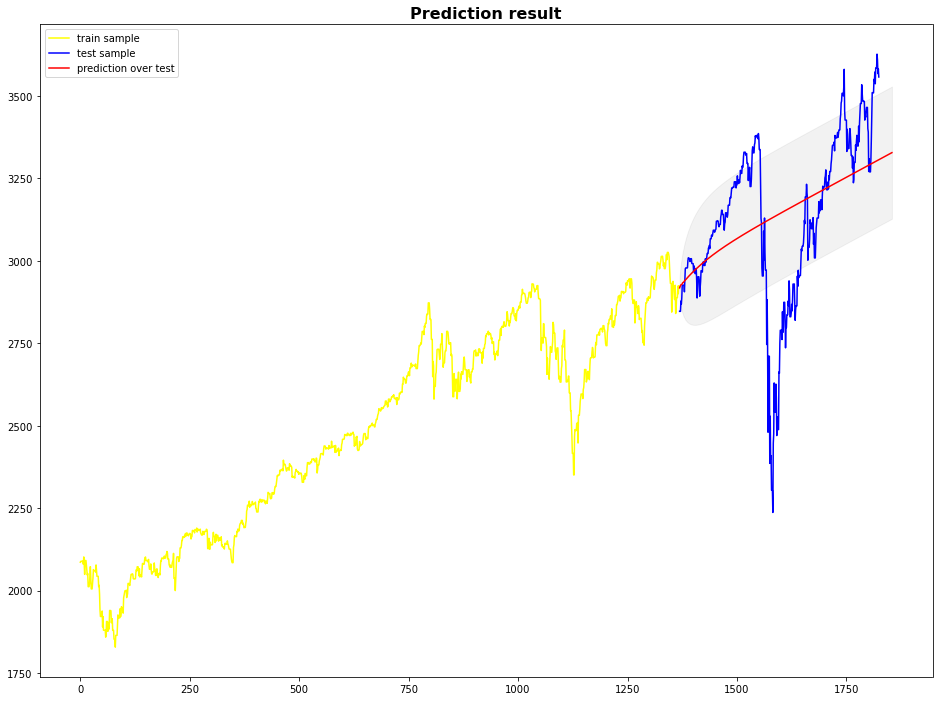

(6, 1, 3, 0.055611661100430525)

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,12

params(df, 0.75, 30)

StackOverflow Questions Count Time Series
https://www.kaggle.com/datasets/aishu200023/stackindex 

In [20]:
df = pd.read_csv("MLTollsStackOverflow.csv", sep = ",")
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


In [21]:
df = df[["month", "python"]]
df = df.rename(columns = {"python": "value"})
df.shape[0]

132

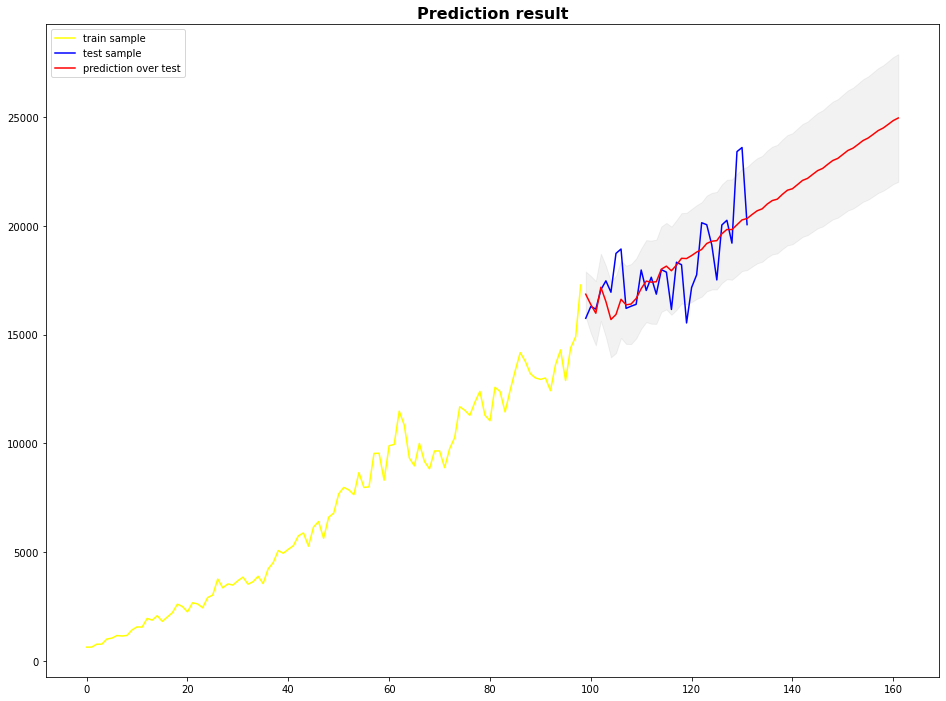

(7, 1, 3, 0.05211221648635837)

In [22]:
params(df, 0.75, 30)

COVID-19 India Time Series
https://www.kaggle.com/datasets/ravichaubey1506/covid19-india

In [24]:
df = pd.read_csv("case_time_series.csv", sep = ",")
df.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30-Jan,1,1,0,0,0,0
1,31-Jan,0,1,0,0,0,0
2,01-Feb,0,1,0,0,0,0
3,02-Feb,1,2,0,0,0,0
4,03-Feb,1,3,0,0,0,0


In [25]:
df = df[["Date", "Daily Confirmed"]]
df = df.rename(columns = {"Daily Confirmed": "value"})
df.shape[0]

93

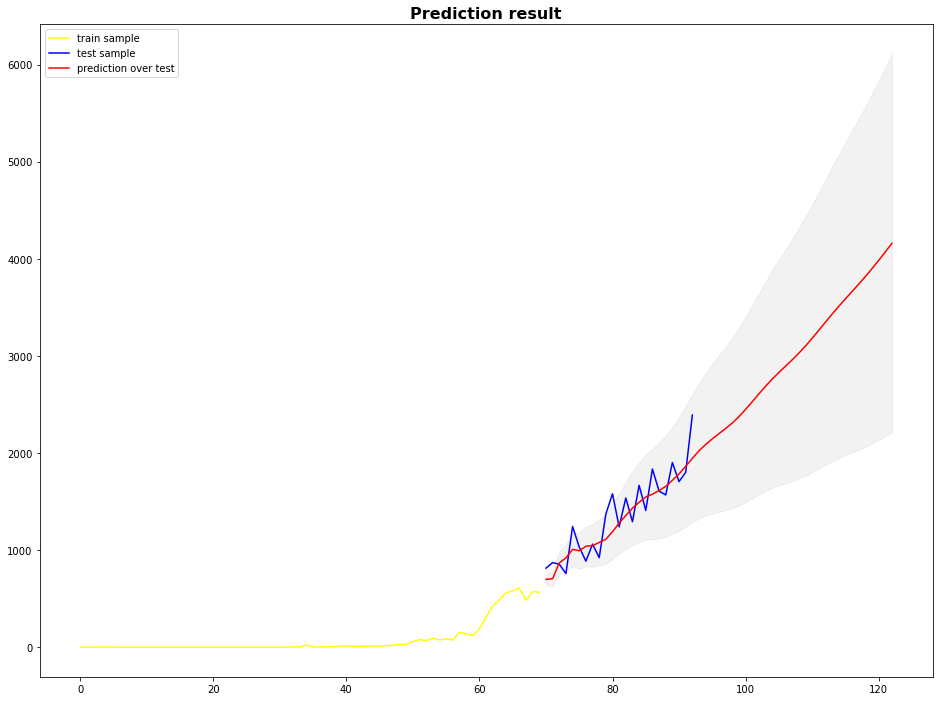

(6, 2, 1, 0.113376735155604)

In [26]:
params(df, 0.75, 30)

Population Time Series Data - explore Time Series from the U.S. Census Bureau
https://www.kaggle.com/datasets/census/population-time-series-data

In [27]:
df = pd.read_csv("POP.csv", sep = ",")
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [28]:
df = df[["date", "value"]]
df.shape[0]

816

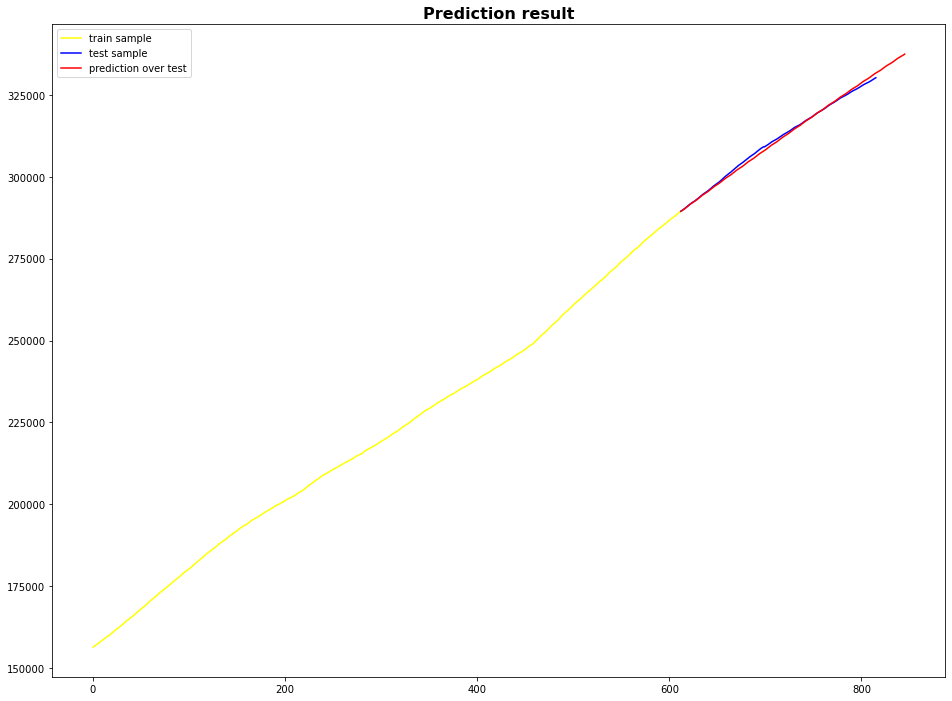

(5, 2, 2, 0.0018495400677221291)

In [29]:
params(df, 0.75, 30)

Well, it works for monotonic functions with excellent 0.2% MAPE, much worse for series with local peaks but could be really useful as a kind of fast rough prediction with wasting the time on finding the correct attributions for each step of model.